### Alien VS Predator 
<p>Goal: Implement a transfer learning solution to classify the 2 Aliens and Predators</p>

In [196]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, dataset


import os
import time as t
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np

from torchvision.datasets import ImageFolder
from torchvision.transforms import (
   Compose, RandomResizedCrop, RandomHorizontalFlip, ToTensor, Resize,
    CenterCrop
)
from torchvision import models

In [197]:
# Lets define our device
device = "cpu"

if torch.backends.mps.is_available:
    device = torch.device('mps')
    print("MPS in use")

MPS in use


In [198]:
train_dir = os.path.join('./alien_vs_predator_thumbnails/data', 'train')
val_dir = os.path.join('./alien_vs_predator_thumbnails/data', 'validation')


In [199]:
train_transforms = Compose([
    RandomResizedCrop(224),
    RandomHorizontalFlip(),
    ToTensor()
])
val_transforms = Compose([
    Resize(256),
    CenterCrop(224),
    ToTensor()
])

train_dataset = ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = ImageFolder(root=val_dir, transform=val_transforms)


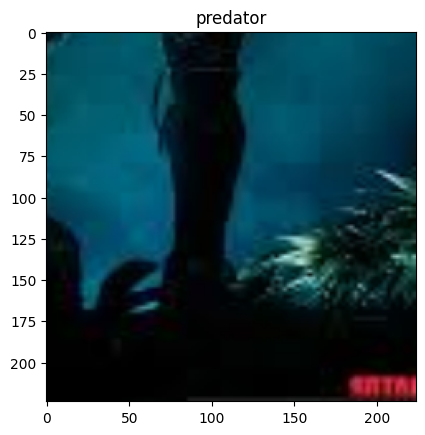

['alien', 'predator']

In [200]:
# Sample Preview
image, label = train_dataset[500]

plt.imshow(image.permute(1, 2, 0))
plt.title(train_dataset.classes[label])
plt.show()

train_dataset.classes


In [201]:
# Prepare the batches
batch_size = 64

train_batch = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_batch = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [202]:
model = models.resnet50(weights='ResNet50_Weights.DEFAULT')
model # Model summary

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [203]:
# Freeze all the layers change the out_feature for the last layer from 1000 to 2
new_layer = nn.Linear(model.fc.in_features, 2)

model.fc = new_layer # Replace the layer
model.to(device=device)


for name, param in model.named_parameters():
     if name not in ['fc.weight', 'fc.bias']:
        param.requires_grad = False # Disable gradient computation

In [204]:
# TODO: Implement a lr_decay implementation 
def train(model, epochs, criterion, optimizer, decay_lr=False, weight_path='default.pth'): 
    model.train()
    loss_history = []

    start = t.time()
    for epoch in range(epochs):
        running_loss = 0.0

        for feature, label in tqdm(train_batch, desc=f"EPOCH: {epoch+1}", leave=True): # leave=True to keep the loader after that itteration
            feature, label = feature.to(device), label.to(device)
            optimizer.zero_grad()
            output = model(feature)
            loss = criterion(output, label)

            running_loss+=loss.item()

            loss.backward()
            optimizer.step()

        loss_history.append(running_loss / len(train_batch))

        print(f"[{epoch+1}]LOSS: {running_loss / len(train_batch)}")
    end = t.time()

    # Save the weight 
    torch.save(model.state_dict(), weight_path)

    
    return loss_history, (end-start)



In [205]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [206]:
epochs = 20
loss_history, training_duration = train(model=model, epochs=epochs, criterion=criterion, optimizer=optimizer)



# epoch_history = [i+1 for i in range(epochs)] # Test Loss vs EPOCHS

# plt.plot(epoch_history, loss_history)
# plt.title("Train loss history")
# plt.xlabel(f"EPOCH: [{epochs}]")
# plt.ylabel(f"LOSS")

# plt.show()

EPOCH: 1: 100%|██████████| 11/11 [00:03<00:00,  3.58it/s]


[1]LOSS: 0.6514417474920099


EPOCH: 2: 100%|██████████| 11/11 [00:02<00:00,  4.03it/s]


[2]LOSS: 0.5005882788788188


EPOCH: 3: 100%|██████████| 11/11 [00:02<00:00,  4.04it/s]


[3]LOSS: 0.41936522180383856


EPOCH: 4: 100%|██████████| 11/11 [00:02<00:00,  4.02it/s]


[4]LOSS: 0.37494219704107806


EPOCH: 5: 100%|██████████| 11/11 [00:02<00:00,  4.04it/s]


[5]LOSS: 0.35790716247125104


EPOCH: 6: 100%|██████████| 11/11 [00:02<00:00,  4.04it/s]


[6]LOSS: 0.3242728059942072


EPOCH: 7: 100%|██████████| 11/11 [00:02<00:00,  4.02it/s]


[7]LOSS: 0.2956800420175899


EPOCH: 8: 100%|██████████| 11/11 [00:02<00:00,  4.05it/s]


[8]LOSS: 0.29682172428477893


EPOCH: 9: 100%|██████████| 11/11 [00:02<00:00,  4.04it/s]


[9]LOSS: 0.3052309914068742


EPOCH: 10: 100%|██████████| 11/11 [00:02<00:00,  4.05it/s]


[10]LOSS: 0.27566931464455346


EPOCH: 11: 100%|██████████| 11/11 [00:02<00:00,  4.04it/s]


[11]LOSS: 0.27457318658178503


EPOCH: 12: 100%|██████████| 11/11 [00:02<00:00,  3.99it/s]


[12]LOSS: 0.26054141602732916


EPOCH: 13: 100%|██████████| 11/11 [00:02<00:00,  4.00it/s]


[13]LOSS: 0.2483539269729094


EPOCH: 14: 100%|██████████| 11/11 [00:02<00:00,  4.00it/s]


[14]LOSS: 0.23857906596227127


EPOCH: 15: 100%|██████████| 11/11 [00:02<00:00,  4.00it/s]


[15]LOSS: 0.22856424884362656


EPOCH: 16: 100%|██████████| 11/11 [00:02<00:00,  4.00it/s]


[16]LOSS: 0.2239614874124527


EPOCH: 17: 100%|██████████| 11/11 [00:02<00:00,  4.01it/s]


[17]LOSS: 0.21957735310901294


EPOCH: 18: 100%|██████████| 11/11 [00:02<00:00,  3.96it/s]


[18]LOSS: 0.22005370936610483


EPOCH: 19: 100%|██████████| 11/11 [00:02<00:00,  3.99it/s]


[19]LOSS: 0.2229189249602231


EPOCH: 20: 100%|██████████| 11/11 [00:02<00:00,  3.97it/s]

[20]LOSS: 0.19770982590588657


In [207]:
def test():
    model.eval()
    with torch.inference_mode():
        total = 0
        correct = 0
        test_loss = 0.0

        for feature, label in tqdm(val_batch):
            feature, label = feature.to(device), label.to(device)

            output = model(feature)
            loss = criterion(output, label)

            test_loss+=loss.item()

            _, pred = torch.max(output, dim=1)

            correct+=(pred == label).sum().item()
            total+=label.size(0)
        
        acc = (correct / total) * 100
        
        return acc, test_loss
test()


100%|██████████| 4/4 [00:00<00:00,  5.29it/s]


(94.5, 0.9916954040527344)

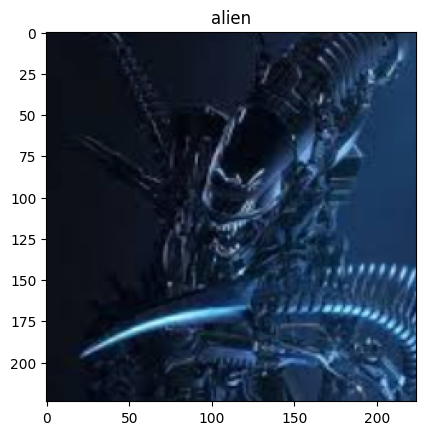

('alien', tensor([0.9868], device='mps:0'))

In [208]:
def predict(model, image_tensor):
    image_tensor = image_tensor.unsqueeze(0).to(device)

    model.eval()
    with torch.inference_mode():
        output = model(image_tensor)

        probs = torch.nn.functional.softmax(output, dim=1)

        conf, predicted_index = torch.max(probs, dim=1)
    
    predicted_class = train_dataset.classes[predicted_index]

    return predicted_class, conf

image, label = val_dataset[0]

plt.imshow(image.permute(1, 2, 0))
plt.title(val_dataset.classes[label])
plt.show()

predict(model, image)